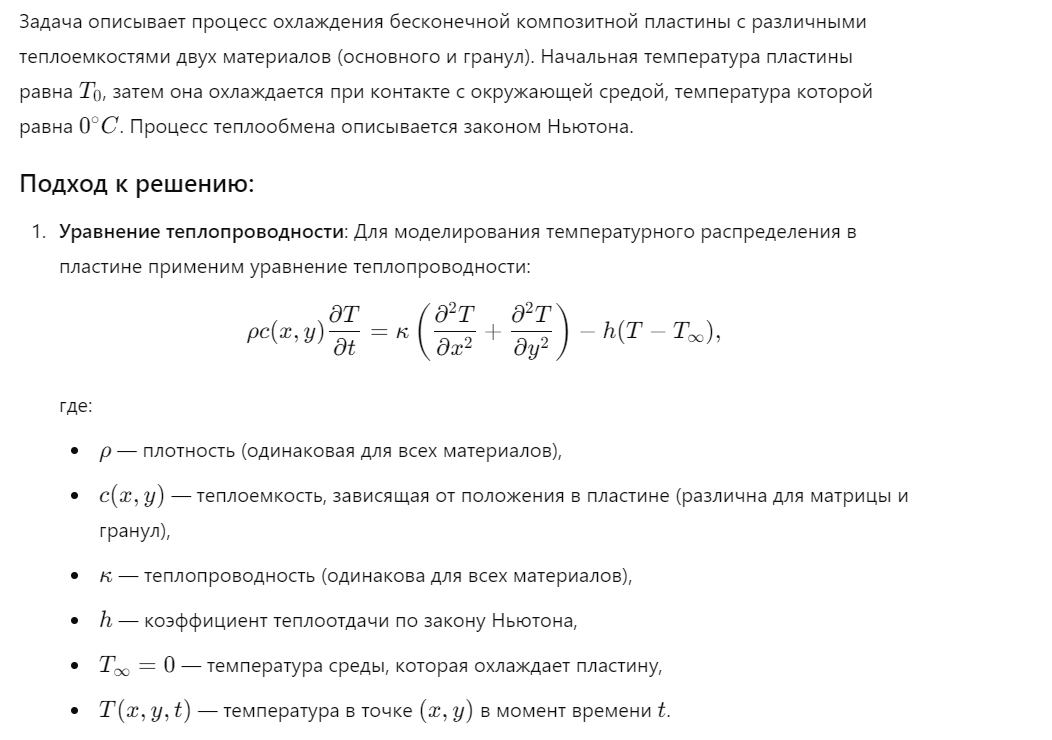

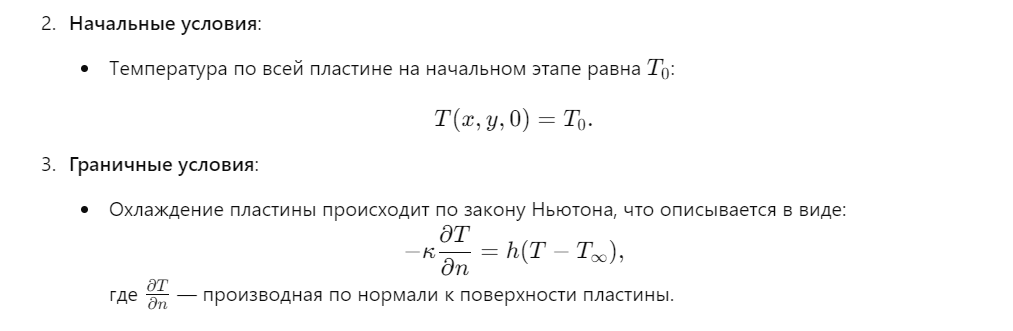

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as lg
from tqdm import tqdm
from IPython.display import clear_output

In [2]:
# Параметры задачи
Lx, Ly = 1.0, 1.0  # Размеры пластины по x и y
Nx, Ny = 60, 60    # Число узлов сетки по x и y
hx, hy = Lx / Nx, Ly / Ny  # Шаг сетки
tau = 1e-2         # Временной шаг
time_steps = 100000  # Количество временных шагов
nu = 0.5 # Параметр схемы Кранка – Николсон


# Параметры материалов
rho = 1.0         # Плотность (одинаковая для матрицы и гранул)
kappa = 1.0       # Теплопроводность (одинаковая для матрицы и гранул)
c_m = 1.0         # Теплоемкость матрицы
c_g = 100.0        # Теплоемкость гранул
T0 = 1.0       # Начальная температура пластины
T_env = 0.0       # Температура окружающей среды (0 градусов)
h = 0.1           # Коэффициент теплоотдачи

In [3]:
# Параметры матрицы и кругов
N = 10           # Количество кругов
matrix_granule = c_g * rho             # Значение внутри кругов
matrix_plastin = c_m * rho           # Значение вне кругов
min_radius = 5     # Минимальный радиус кругов
max_radius = 10    # Максимальный радиус кругов

In [7]:
class Solution:


    @staticmethod
    def create_circle_matrix(matrix_size, N, a1, a2, min_radius, max_radius):
        np.random.seed(42)
        # Инициализируем матрицу значениями a2
        matrix = np.full((Nx, Ny), a2)

        # Генерируем N кругов
        for _ in range(N):
            # Случайная позиция центра круга
            center_x = np.random.randint(0, matrix_size)
            center_y = np.random.randint(0, matrix_size)

            # Случайный радиус
            radius = np.random.randint(min_radius, max_radius)

            # Проходим по каждому элементу матрицы
            for i in range(matrix_size):
                for j in range(matrix_size):
                    # Проверяем, находится ли точка внутри круга
                    if (i - center_x) ** 2 + (j - center_y) ** 2 < radius ** 2:
                        matrix[i, j] = a1

        return matrix

    @staticmethod
    def F_right() -> np.array:
        """
        Инициализация и заполнение матрицы значением h * T_env.
        
        Создает numpy array размера Nx * Ny и заполняет его значением h * T_env
        
        :return:  матрица в формате np.array.
        """
        return np.full((Nx, Ny), h * T_env)

    @staticmethod
    def init_lil_matrix() -> sp.lil_matrix:
        """
        Инициализация и заполнение разреженной матрицы в формате LIL.
        
        Создает разреженную матрицу с коэффициентами для задачи, основываясь на
        сетке с шагами hx и hy. Учитывает граничные условия через периодичность индексов.
        
        :return: Разреженная матрица в формате LIL.
        :rtype: sp.lil_matrix
        """
        L = sp.lil_matrix((Nx * Ny, Nx * Ny))
        k = np.arange(Nx * Ny, dtype=int).reshape((Nx, Ny))
        for i in range(Nx):
            for j in range(Ny):
                L[k[i, j], k[i, j]] += 2.0 / hx ** 2 + 2.0 / hy ** 2 + h
                L[k[i, j], k[(i - 1) % Nx, j]] = -1.0 / hx ** 2 
                L[k[i, j], k[(i + 1) % Nx, j]] = -1.0 / hx ** 2 
                L[k[i, j], k[i, (j - 1) % Ny]] = -1.0 / hy ** 2 
                L[k[i, j], k[i, (j + 1) % Ny]] = -1.0 / hy ** 2
                
        return L
    

    def main(self):
        
        P = self.create_circle_matrix(Nx, N, matrix_granule, matrix_plastin, min_radius, max_radius)
        eye = sp.eye(Nx * Ny, format='csr')

        P_inv = sp.diags(1 / P.ravel(), format='csr')
        L = self.init_lil_matrix()
        F = self.F_right()


        A = eye + tau * nu * P_inv @ L
        B = eye - tau * (1 - nu) * P_inv @ L
        C = tau * P_inv @ F.flatten()

        u = np.full((Nx * Ny), fill_value=T0)

        for i in range(time_steps):
            u, _ = lg.cg(A, B @ u + C, x0=u)
            if i % 200 == 0:
                clear_output(True)
                plt.title(f'iteration {i=}'.format(i=i))
                plt.imshow(u.reshape(Nx, Ny), cmap='hot')
                plt.colorbar()
                plt.show()
        

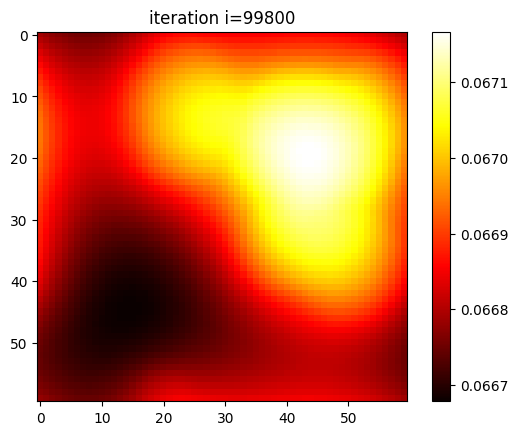

In [8]:
solver = Solution()
solver.main()